# Table: pvals (perf + align)

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from figures.tables import table_pvals
from figures.box import plot_box

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
skip_fits = [
    'fixate2_nf-420_beta-0.15_(2023_04_27,13:57)',
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15)',
]

## Load

### df neural

In [3]:
path = pjoin(tmp_dir, 'results_combined')
fits = []
with open(pjoin(path, 'fits.txt'), 'r') as f:
    for line in f:
        if '# computer name' in line:
            continue
        fits.append(line.split('\n')[0])

In [4]:
df_neural = []
for fit in fits:
    if 'reservoir' in fit or fit in skip_fits:
        continue
    category, nf, beta, tag = extract_info(fit)    
    if beta in [0.001, 20.0]:
        continue

    # load df
    _df = f"summary_{fit}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    assert len(_df) == 141
    _df.insert(0, 'model', tag)
    df_neural.append(_df)

df_neural = pd.concat(df_neural).reset_index()

### df align

In [5]:
path = pjoin(tmp_dir, 'neural_analysis')

In [6]:
df_align = collections.defaultdict(list)
for fit in tqdm(sorted(os.listdir(path))):
    if 'reservoir' in fit or fit in skip_fits:
        continue
    category, nf, beta, tag = extract_info(fit)    
    if beta in [0.001, 20.0]:
        continue

    # load npy
    results = np.load(
        pjoin(path, fit),
        allow_pickle=True,
    ).item()
    
    # get alignment scores
    for k, a in results['alignment_score'].items():
        _, expt, cell = k.split('_')
        df_align['model'].append(tag)
        df_align['category'].append(category)
        df_align['beta'].append(beta)
        df_align['nf'].append(nf)
        df_align['expt'].append(expt)
        df_align['cell'].append(int(cell))
        df_align['a'].append(a)

df_align = pd.DataFrame(df_align)
betas = ['ae'] + sorted([
    b for b in df_align['beta'].unique()
    if isinstance(b, float)
])

100%|██████████| 68/68 [16:01<00:00, 14.13s/it]


In [7]:
df_align.shape, df_neural.shape

((9073, 7), (10857, 12))

## Merge dfs

In [8]:
df = df_neural.copy()
df['a'] = np.nan

In [9]:
for _, row in tqdm(df_align.iterrows()):
    df.loc[
        (df['model'] == row['model']) &
        (df['category'] == row['category']) &
        (df['beta'] == row['beta']) &
        (df['nf'] == row['nf']) &
        (df['expt'] == row['expt']) &
        (df['cell'] == row['cell']),
        'a',
    ] = row['a']

9073it [00:28, 319.45it/s]


In [10]:
df['both'] = df['perf'] * df['a']

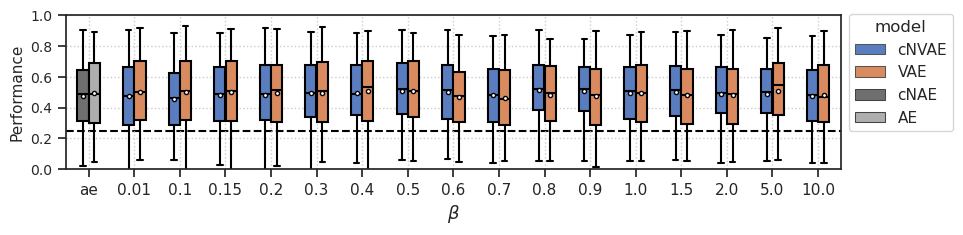

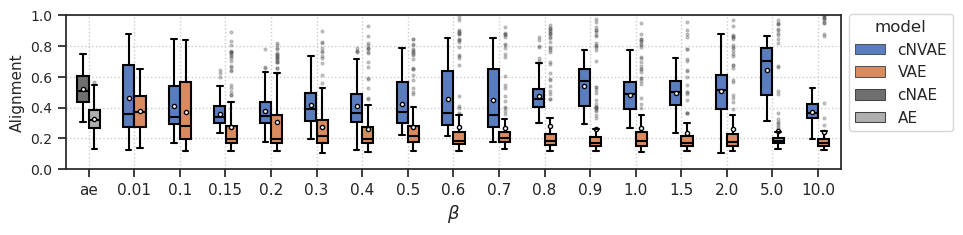

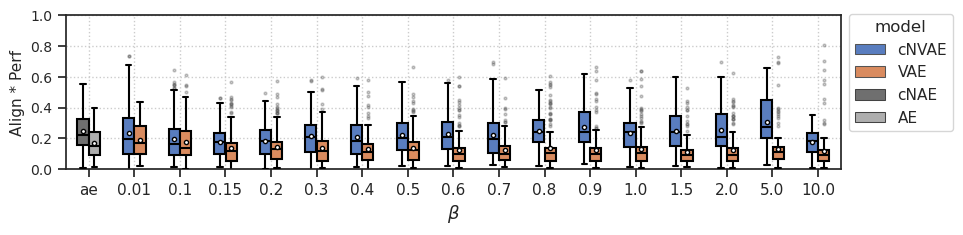

In [11]:
fig, ax = plot_box(df, 'perf', 'Performance', display=False)
ax.axhline(0.251, color='k', ls='--', zorder=0)
display(fig)

fig, ax = plot_box(df, 'a', 'Alignment')

fig, ax = plot_box(df, 'both', 'Align * Perf')

## $t-$test

In [42]:
table, df_pvals, alphac_bonf = table_pvals(df)
print(alphac_bonf)

0.0014705882352941176

In [43]:
print(table)

ae & -0.23 & 0.01 & \cmark & 1.2 & 8e-29 & \cmark\\
0.01 & -0.28 & 0.002 & \cmark & 0.32 & 0.0004 & \cmark\\
0.1 & -0.47 & 2e-07 & \cmark & 0.12 & 0.2 & \xmark\\
0.15 & -0.16 & 0.07 & \xmark & 0.46 & 4e-07 & \cmark\\
0.2 & -0.14 & 0.1 & \xmark & 0.33 & 0.0003 & \cmark\\
0.3 & -0.012 & 0.9 & \xmark & 0.69 & 4e-13 & \cmark\\
0.4 & -0.15 & 0.09 & \xmark & 0.65 & 7e-12 & \cmark\\
0.5 & -0.013 & 0.9 & \xmark & 0.65 & 7e-12 & \cmark\\
0.6 & 0.29 & 0.001 & \cmark & 0.69 & 4e-13 & \cmark\\
0.7 & 0.16 & 0.08 & \xmark & 0.71 & 1e-13 & \cmark\\
0.8 & 0.44 & 1e-06 & \cmark & 0.73 & 4e-14 & \cmark\\
0.9 & 0.24 & 0.008 & \cmark & 0.96 & 1e-20 & \cmark\\
1.0 & 0.0016 & 1 & \xmark & 0.89 & 1e-18 & \cmark\\
1.5 & 0.17 & 0.07 & \xmark & 1.2 & 3e-28 & \cmark\\
2.0 & 0.037 & 0.7 & \xmark & 0.91 & 3e-19 & \cmark\\
5.0 & -0.24 & 0.008 & \cmark & 1.3 & 7e-31 & \cmark\\
10.0 & -0.056 & 0.6 & \xmark & 0.55 & 3e-09 & \cmark\\

### tblr settings

In [14]:
len(betas)

17

In [15]:
cells = []
for i in range(len(betas)):
    s = []
    for j in range(1, 7 + 1):
        s.append('='.join([
            f"cell{'{'}{3+i}{'}'}{'{'}{j}{'}'}",
            f"{'{'}c=1{'}'}{'{'}c{'}'},\n",
        ]))
    cells.append(''.join(s))
cells = ''.join(cells)

In [16]:
print(cells)

cell{3}{1}={c=1}{c},
cell{3}{2}={c=1}{c},
cell{3}{3}={c=1}{c},
cell{3}{4}={c=1}{c},
cell{3}{5}={c=1}{c},
cell{3}{6}={c=1}{c},
cell{3}{7}={c=1}{c},
cell{4}{1}={c=1}{c},
cell{4}{2}={c=1}{c},
cell{4}{3}={c=1}{c},
cell{4}{4}={c=1}{c},
cell{4}{5}={c=1}{c},
cell{4}{6}={c=1}{c},
cell{4}{7}={c=1}{c},
cell{5}{1}={c=1}{c},
cell{5}{2}={c=1}{c},
cell{5}{3}={c=1}{c},
cell{5}{4}={c=1}{c},
cell{5}{5}={c=1}{c},
cell{5}{6}={c=1}{c},
cell{5}{7}={c=1}{c},
cell{6}{1}={c=1}{c},
cell{6}{2}={c=1}{c},
cell{6}{3}={c=1}{c},
cell{6}{4}={c=1}{c},
cell{6}{5}={c=1}{c},
cell{6}{6}={c=1}{c},
cell{6}{7}={c=1}{c},
cell{7}{1}={c=1}{c},
cell{7}{2}={c=1}{c},
cell{7}{3}={c=1}{c},
cell{7}{4}={c=1}{c},
cell{7}{5}={c=1}{c},
cell{7}{6}={c=1}{c},
cell{7}{7}={c=1}{c},
cell{8}{1}={c=1}{c},
cell{8}{2}={c=1}{c},
cell{8}{3}={c=1}{c},
cell{8}{4}={c=1}{c},
cell{8}{5}={c=1}{c},
cell{8}{6}={c=1}{c},
cell{8}{7}={c=1}{c},
cell{9}{1}={c=1}{c},
cell{9}{2}={c=1}{c},
cell{9}{3}={c=1}{c},
cell{9}{4}={c=1}{c},
cell{9}{5}={c=1}{c},
cell{9}{6}={c=1}{c},
cell{9}{7}={c=1}{c},
cell{10}{1}={c=1}{c},
cell{10}{2}={c=1}{c},
cell{10}{3}={c=1}{c},
cell{10}{4}={c=1}{c},
cell{10}{5}={c=1}{c},
cell{10}{6}={c=1}{c},
cell{10}{7}={c=1}{c},
cell{11}{1}={c=1}{c},
cell{11}{2}={c=1}{c},
cell{11}{3}={c=1}{c},
cell{11}{4}={c=1}{c},
cell{11}{5}={c=1}{c},
cell{11}{6}={c=1}{c},
cell{11}{7}={c=1}{c},
cell{12}{1}={c=1}{c},
cell{12}{2}={c=1}{c},
cell{12}{3}={c=1}{c},
cell{12}{4}={c=1}{c},
cell{12}{5}={c=1}{c},
cell{12}{6}={c=1}{c},
cell{12}{7}={c=1}{c},
cell{13}{1}={c=1}{c},
cell{13}{2}={c=1}{c},
cell{13}{3}={c=1}{c},
cell{13}{4}={c=1}{c},
cell{13}{5}={c=1}{c},
cell{13}{6}={c=1}{c},
cell{13}{7}={c=1}{c},
cell{14}{1}={c=1}{c},
cell{14}{2}={c=1}{c},
cell{14}{3}={c=1}{c},
cell{14}{4}={c=1}{c},
cell{14}{5}={c=1}{c},
cell{14}{6}={c=1}{c},
cell{14}{7}={c=1}{c},
cell{15}{1}={c=1}{c},
cell{15}{2}={c=1}{c},
cell{15}{3}={c=1}{c},
cell{15}{4}={c=1}{c},
cell{15}{5}={c=1}{c},
cell{15}{6}={c=1}{c},
cell{15}{7}={c=1}{c},
cell{16}{1}={c=1}{c},
cell{16}{2}={c=1}{c},
cell{16}{3}={c=1}{c},
cell{16}{4}={c=1}{c},
cell{16}{5}={c=1}{c},
cell{16}{6}={c=1}{c},
cell{16}{7}={c=1}{c},
cell{17}{1}={c=1}{c},
cell{17}{2}={c=1}{c},
cell{17}{3}={c=1}{c},
cell{17}{4}={c=1}{c},
cell{17}{5}={c=1}{c},
cell{17}{6}={c=1}{c},
cell{17}{7}={c=1}{c},
cell{18}{1}={c=1}{c},
cell{18}{2}={c=1}{c},
cell{18}{3}={c=1}{c},
cell{18}{4}={c=1}{c},
cell{18}{5}={c=1}{c},
cell{18}{6}={c=1}{c},
cell{18}{7}={c=1}{c},
cell{19}{1}={c=1}{c},
cell{19}{2}={c=1}{c},
cell{19}{3}={c=1}{c},
cell{19}{4}={c=1}{c},
cell{19}{5}={c=1}{c},
cell{19}{6}={c=1}{c},
cell{19}{7}={c=1}{c},

In [32]:
df

,index,model,category,nf,beta,root,expt,cell,perf,max_perf,log_alpha,best_lag,a,both
0,0,cNVAE,fixate0,280,1.0,YUWEI,clu036,0,0.120645,NaN,3.0,2,0.251409,0.030331
1,1,cNVAE,fixate0,280,1.0,YUWEI,clu037,0,0.232414,NaN,-4.0,9,0.691780,0.160779
2,2,cNVAE,fixate0,280,1.0,YUWEI,clu038,0,0.332532,NaN,-2.0,0,0.625165,0.207887
3,3,cNVAE,fixate0,280,1.0,YUWEI,clu039,0,0.321147,NaN,-4.0,0,0.673199,0.216196
4,4,cNVAE,fixate0,280,1.0,YUWEI,clu040,0,0.455445,NaN,-4.0,2,0.651220,0.296595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10852,136,AE,fixate1,420,ae,YUWEI,ytu029,19,0.327538,0.941254,-4.0,7,0.464388,0.152105
10853,137,AE,fixate1,420,ae,YUWEI,ytu029,20,0.245676,0.958395,-1.0,5,0.288113,0.070782
10854,138,AE,fixate1,420,ae,YUWEI,ytu029,21,0.342485,0.846710,-1.0,4,0.264531,0.090598
10855,139,AE,fixate1,420,ae,YUWEI,ytu029,22,0.621532,0.930033,-10.0,4,0.302297,0.187888


## Plot effect sizes

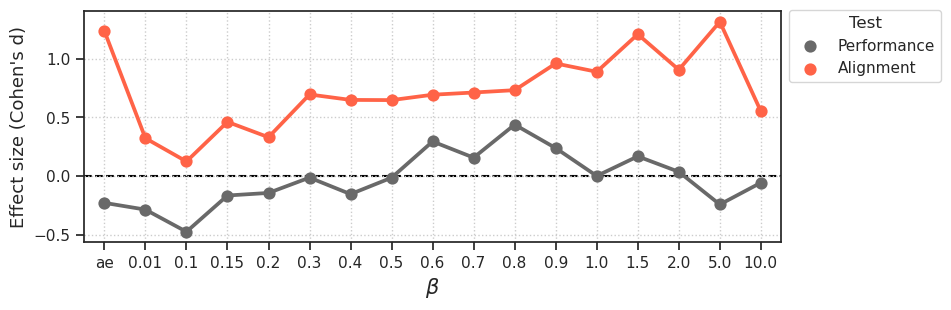

In [84]:
fig, ax = create_figure(1, 1, (9, 3))
sns.pointplot(
    data=df_pvals,
    x='beta',
    y='cohens_d',
    hue='test',
    palette={'a': 'tomato', 'perf': 'dimgrey'},
    ax=ax,
)
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel("Effect size (Cohen's d)", fontsize=13)
ax.axhline(0, color='k', ls='--', zorder=0)
ax.grid()

leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1.04))
leg.set_title('Test')

for t, new_t in zip(leg.get_texts(), ('Performance', 'Alignment')):
    t.set_text(new_t)

plt.show()

In [85]:
fig.savefig(pjoin(fig_base_dir, 'effect_sizes.pdf'), **kws_fig)